# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [557]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# % matplotlib inline

data_path = 'data'

# read in the json files
portfolio_df = pd.read_json(f'{data_path}/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json(f'{data_path}/profile.json', orient='records', lines=True)
transcript_df = pd.read_json(f'{data_path}/transcript.json', orient='records', lines=True)

## Data Exploration

### Portfolio

In [ ]:
portfolio_df.head()

In [ ]:
unique_offers_count = portfolio_df['id'].nunique()
print(f"The portfolio contains {unique_offers_count} distinct offers.")

print("Distribution of the offers:")
offer_type_distribution = portfolio_df.offer_type.value_counts()
print(offer_type_distribution)


The various channels and offer types require distinct representation for analysis. Therefore, it is necessary to convert categorical variables into indicator variables

In [ ]:
# Convert categorical variables into indicator variables for channels
channel_dummies = pd.get_dummies(portfolio_df['channels'].apply(pd.Series).stack()).sum(level=0)
portfolio_df = pd.concat([portfolio_df, channel_dummies], axis=1)

# Drop the 'channels' column
portfolio_df.drop(columns=['channels'], inplace=True)

# Create a new 'offer' column with concatenated information
portfolio_df['offer'] = (portfolio_df['offer_type'] + "_" + portfolio_df['reward'].astype(str) +
                      "_for_" + portfolio['difficulty'].astype(str) + "_in_" +
                      portfolio_df['duration'].astype(str) + "days")

portfolio_df.head()

In [ ]:
# Convert offer types into indicator variables
offer_type_dummies = pd.get_dummies(portfolio_df['offer_type'])
portfolio_df = pd.concat([portfolio_df, offer_type_dummies], axis=1)

# Rename the 'id' column to 'offer_id'
portfolio_df.rename(columns={'id': 'offer_id'}, inplace=True)

portfolio_df


## Profile

In [ ]:
profile_df.head()

For some entries, the age is  118, which doesn't seem to be plausible.
Also there are some NaN values. First, the NaN values will be dropped, before I take a closer look at the age distribution.

In [ ]:
nan_count = profile_df.isna().sum().sum()
print("Number of NaN values in profile_df:", nan_count)

In [ ]:
profile_df.dropna(inplace=True)

Let's have a look how the age is distributed and if the age values are plausible

In [ ]:
# Create histogram using Seaborn
sns.histplot(profile_df['age'], bins=50, kde=True)  # Adjust bins and kde as needed
plt.title('Distribution of Age in profule dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
profile_df['age'].max(), profile_df['age'].min()

The age distribution and maximum and minumum age look plausible now.

The following steps will be carried out with the next section of Code:

* Rename the 'id' column to 'customer_id' and reorder columns
* Calculate membership duration
* Drop the 'became_member_on' column if membership duration has been calculated
* Reset index and display the DataFrame

In [ ]:
# Rename the 'id' column to 'customer_id' and reorder columns
profile_df = profile_df.rename(columns={'id': 'customer_id'})
columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on']
profile_df = profile_df.reindex(columns=columns_order)

# Calculate membership duration
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')
profile_df['membership_duration_days'] = (datetime.datetime.today().date() - profile_df['became_member_on'].dt.date).dt.days

# Drop the 'became_member_on' column if membership duration has been calculated
columns_order.append('membership_duration_days')
profile_df = profile_df.reindex(columns=columns_order)

# Reset index and display the DataFrame
profile_df = profile_df.reset_index(drop=True)
profile_df.head()

## Transcript

In [ ]:
transcript_df.head()

In [ ]:
transcript_df.info()

In [ ]:
# value counts of transcations
transcript_df['event'].value_counts()

Filtering Transcript Data Based on Customer IDs Present in Profile Data

In [ ]:
# Filtering Transcript Data Based on Customer IDs Present in Profile Data

# Filter transcript data based on customer IDs present in profile data
transcript_df = transcript_df[transcript_df['person'].isin(profile_df['customer_id'])]

# Print the length of the filtered transcript dataframe
print("Length of filtered transcript dataframe:", len(transcript_df))

# Display the first few rows of the filtered transcript dataframe
transcript_df.head()


Creating DataFrame with Details of Customer IDs and Amount Spent by Each Customer

In [ ]:
# Creating DataFrame with Details of Customer IDs and Amount Spent by Each Customer

# Filter transcript data for transactions
df_trans = transcript_df[transcript_df['event'] == 'transaction']

# Create DataFrame for amount spent by each customer
customer_spending_df = pd.DataFrame(data=df_trans)

# Drop unnecessary columns
customer_spending_df = customer_spending_df.drop(['value', 'event'], axis=1)

# Extract amount from the 'value' column
customer_spending_df['amount'] = df_trans['value'].apply(lambda x: list(x.values())[0])

# Rename the 'person' column to 'customer_id'
customer_spending_df = customer_spending_df.rename(columns={'person': 'customer_id'})

# Merge with profile DataFrame to include gender information
customer_spending_df = pd.merge(customer_spending_df, profile_df[['gender', 'customer_id']], how='left', on='customer_id')

# Reset index
customer_spending_df = customer_spending_df.reset_index(drop=True)

# Display the first few rows of the customer_spending_df dataframe
customer_spending_df.head()

This code analyzes customer spending habits based on gender. It calculates the average amount spent per transaction for each gender category (male, female, other) using data from the 'customer_spending_df' DataFrame. The results are visualized using a bar plot to compare the average spending across different gender groups.

In [ ]:
# Group by gender
gender_groupby = customer_spending_df.groupby('gender')

# Calculate total amount spent and total number of transactions by gender
gender_expense = gender_groupby.amount.sum()
gender_transactions = gender_groupby.size()

# Calculate average amount spent per transaction for each gender
average_spending_per_transaction = gender_expense / gender_transactions

# Plot the average amount spent per transaction by gender using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=average_spending_per_transaction.index, y=average_spending_per_transaction.values, palette='muted')

# Label the plot
plt.title('Average Amount Spent per Transaction by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Amount Spent per Transaction')
plt.show()

It can be seen that from all genders, women spend most per transaction.

Let's see which genders spends the most money in total:

In [ ]:
# Calculate total spending for each gender
total_spending_by_gender = gender_groupby.amount.sum()

# Find the gender with the highest total spending
highest_spending_gender = total_spending_by_gender.idxmax()

# Print the result
print(f"The gender that spends the most money is: {highest_spending_gender} (Total spending: ${total_spending_by_gender[highest_spending_gender]:.2f})")

The following code unpacks information stored within the 'value' column of the 'transcript_df' DataFrame into separate columns ('offer_id', 'amount', 'reward'). It replaces missing values in the 'offer_id' column and removes redundant columns ('value', 'offer id'). The result is a DataFrame with unpacked information for further analysis.

In [ ]:

# Expand the 'value' column into separate columns and merge with the original DataFrame

# First, expand the 'value' column into separate columns
expanded_values = transcript_df['value'].apply(lambda x: pd.Series(x))

# Next, we handle the 'offer id' and 'offer_id' overlap by checking for their existence and combining them into one
expanded_values['offer_id'] = expanded_values.get('offer_id').fillna(expanded_values.get('offer id'))
# Drop the 'offer id' column if it exists, as its information is now merged into 'offer_id'
expanded_values.drop(columns=['offer id'], errors='ignore', inplace=True)

# Now, drop the original 'value' column from the transcript DataFrame to avoid duplication when merging
transcript_df.drop(columns=['value'], inplace=True)

# Finally, concatenate the modified expanded_values DataFrame with the original transcript DataFrame
transcript_df = pd.concat([transcript_df, expanded_values], axis=1)

transcript_df.head()

In the next code segment, I focus on refining our dataset to better understand customer interactions with received offers. I want to calculate the total number of offers each customer receives, convert event types into easily analyzable formats, and streamline our dataset by adjusting column names and removing extraneous information.

In [ ]:
# Count the number of offers received per person and merge with the original DataFrame
offers_received = transcript_df[transcript_df['event'] == 'offer received'].groupby('person')['event'].size().reset_index(name='num_offers_received')
transcript_df = transcript_df.merge(offers_received, how='left', on='person')

# Convert 'event' categories into indicator variables and merge with the original DataFrame
transcript_df = pd.concat([transcript_df, pd.get_dummies(transcript_df['event'], prefix='event')], axis=1)

# Drop unnecessary columns and rename 'person' to 'customer_id'
transcript_df.drop(columns=['offer id', 'value', 'reward'], errors='ignore', inplace=True)
transcript_df.rename(columns={'person': 'customer_id'}, inplace=True)

# Display the first three rows to verify changes
transcript_df.head()


Merge transcript and portfolio dataframes to create a more comprehensive dataset for analysis.

In [ ]:
combined_df = pd.merge(transcript_df, portfolio_df, on='offer_id', how='left')

Plotting the distribution of Events by Offer Type

In [ ]:
# prepare the data by counting occurrences for plotting
event_counts = combined_df[combined_df['event'] != 'transaction'].groupby(['offer_type', 'event'])['customer_id'].count().reset_index()

# Use barplot to visualize the data
plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility
sns.barplot(data=event_counts, x='offer_type', y='customer_id', hue='event', palette='coolwarm')

# Enhancements for readability
plt.xlabel('Offer Type', fontsize=14)  # Label for x-axis
plt.ylabel('Count', fontsize=14)  # Label for y-axis
plt.title('Distribution of Events by Offer Type', fontsize=16)  # Title for the plot
plt.legend(title='Event Type')  # Legend with title

# Adding annotations to each bar for clarity
for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 10), 
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [ ]:
combined_df.head()

In [ ]:
combined_df = combined_df.rename(columns={
    'num_offers_received': 'num_offers',
    'event_offer completed': 'offer completed',
    'event_offer received': 'offer received',
    'event_offer viewed': 'offer viewed',
    'event_transaction': 'transaction'
})

In [ ]:
combined_df.columns

## Data Preparation

To optimize the effectiveness of the predictive model, the current dataset requires further refinement. While initial data cleaning has been conducted, the dataset is not yet in a state suitable for modeling purposes.

A new column will be introduced to delineate which instances in the dataset represent successful outcomes. Given that BOGO and discount offers are marked by 'offer completed' events, whereas informational offers lack such markers, it's necessary to prepare the datasets for each offer type distinctly, starting with BOGO and discount offers.

### BOGO and Discount Offers Analysis
Typically, the journey of BOGO and discount offers through the system can follow one of these scenarios:

1. **Successful offer completion**: The sequence of offer received → offer viewed → one or more transactions → offer completed, signifies a fully successful engagement, which is the desired result.
2. **Viewed but ineffective offer**: Here, an offer is received and viewed, but does not lead to any transaction.
3. **Offer ignored**: The offer is received but not even viewed.
4. **Completion without view**: The offer is received, and, without being viewed, transactions are made, and the offer is completed.

A scenario where the offer is viewed and leads to a completed transaction is the optimal path, indicating a desired and effective interaction. Scenarios indicating the offer was viewed but did not result in a transaction, or the offer was never viewed, represent unsuccessful engagements. These are considered as the offer failing to motivate the customer towards making a purchase. However, instances where offers are completed without being viewed also need to be distinguished. These instances suggest that purchases would have occurred irrespective of the offer's presence, highlighting a distinct customer behavior pattern.

It's crucial to distinguish between these outcomes, particularly separating those who complete offers without viewing them from those who follow the full path of viewing and completing offers. Such differentiation aids in accurately targeting the right consumer segments.

Starbucks would ideally focus its efforts on customers who complete offers after viewing them, as this indicates a direct influence of the offer on customer behavior. Conversely, efforts might be less effective on customers who tend to complete offers without viewing them or do not respond to offers, as this indicates either an innate likelihood to purchase or a disinterest in promotions, making discounts or BOGO offers less economically viable for Starbucks.


In [401]:
def offer_completion_evaluation(df):
    """
    Evaluates offer completion effectiveness from the provided DataFrame.

    This function processes the input DataFrame to determine the success,
    unviewed success, and failure of offers based on event types. It then merges 
    additional information from portfolio and profile data, and assigns outcome 
    categories and factors to each offer.

    Parameters:
    df (DataFrame): Input DataFrame containing offer events.

    Returns:
    DataFrame: A DataFrame with offers classified into success, unviewed success,
    or failure, merged with portfolio and profile information, and including 
    an outcome factor.
    """
    
    # Disable warning for chained assignment to allow inplace operations without interruption.
    pd.options.mode.chained_assignment = None

    # Filter and sort offers based on viewing and completion.
    offers_completed = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']]\
                        .query("event in ['offer viewed', 'offer completed']")\
                        .sort_values(by=['customer_id', 'time'])

    # Shift offer_id to the next row within each group for comparison.
    offers_completed['previous_offer_id'] = offers_completed.groupby(['customer_id', 'offer_id'])['offer_id'].shift()

    # Define success based on completion of the viewed offer.
    offers_completed['success'] = ((offers_completed['event'] == 'offer completed') & 
                                   (offers_completed['previous_offer_id'] == offers_completed['offer_id'])).astype(int)

    # Define unviewed success if an offer is completed without a prior view.
    offers_completed['unviewed_success'] = ((offers_completed['event'] == 'offer completed') &
                                            (offers_completed['previous_offer_id'].isna())).astype(int)

    # Clean up by dropping the auxiliary column.
    offers_completed.drop(['previous_offer_id'], axis=1, inplace=True)

    # Select and sort received offers.
    received_offers = df.loc[df['event'] == 'offer received', ['customer_id', 'event', 'time', 'offer_id', 'num_offers']]\
                        .sort_values(by=['customer_id', 'time'])

    # Combine received with viewed and completed offers.
    together = received_offers.append(offers_completed).sort_values(by=['customer_id', 'time'])

    # Filter combined DataFrame for success analysis.
    successes = together.query("event in ['offer received', 'offer completed']")

    # Backfill success indicators for a coherent success analysis.
    for col in ['success', 'unviewed_success']:
        successes[col] = successes.groupby(['customer_id', 'offer_id'])[col].bfill()

    # Focus on received offers for final analysis.
    result = successes.query("event == 'offer received'")

    # Classify offers without success or unviewed success as failures.
    result['failure'] = ((result['success'].isna()) & (result['unviewed_success'].isna())).astype(int)
    result['success'] = result['success'].fillna(0).astype(int)
    result['unviewed_success'] = result['unviewed_success'].fillna(0).astype(int)

    # Define conditions and choices for offer outcome classification.
    conditions = [result['success'] == 1, result['unviewed_success'] == 1]
    choices = ['success', 'unviewed success']
    
    # Assign outcome labels based on conditions.
    result['outcome'] = np.select(conditions, choices, default='failure')

    # Map outcome labels to numerical factors for analysis.
    result['outcome_factor'] = result['outcome'].replace({'failure': 0, 'unviewed success': 1, 'success': 2})

    # Merge additional customer and offer information, dropping unnecessary columns.
    combined = (result.merge(portfolio_df, on='offer_id', how='left')
                      .merge(profile_df, on='customer_id', how='left')
                      .drop(columns=['event', 'became_member_on']))

    # Re-enable chained assignment warning.
    pd.options.mode.chained_assignment = "warn"

    return combined


In [517]:
# Filter and clean in a streamlined fashion
bogo_discount_notcleaned = pd.concat([combined_df[combined_df['offer_type'] == 'bogo'],
                                      combined_df[combined_df['offer_type'] == 'discount']])

# Apply cleaning function directly within the concat function
data_bogo_discount_df = pd.concat([offer_completion_evaluation(combined_df[combined_df['offer_type'] == 'bogo']),
                           offer_completion_evaluation(combined_df[combined_df['offer_type'] == 'discount'])])

data_bogo_discount_df.head()

,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,social,web,offer,bogo,discount,informational,gender,age,income,membership_duration_days
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,33,72000.0,2532
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,1,0,0,O,40,57000.0,2269
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,0,bogo_10_for_10_in_7days,1,0,0,F,59,90000.0,2945
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10,...,1,1,bogo_10_for_10_in_5days,1,0,0,F,59,90000.0,2945
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,F,24,60000.0,2693


In [518]:
def clean_transaction_data(df):
    """
    Cleans and transforms a dataframe containing transaction and offer events for further analysis.
    
    The function performs several operations to prepare the data for analysis:
    - Sorts the dataframe by customer ID and time to ensure chronological order.
    - Calculates the duration of offers in hours and assigns end times for offers based on their duration.
    - Fills forward the end times within each customer group to account for ongoing offers.
    - Identifies and flags transactions that occur within the valid offer period.
    - Filters out transactions without associated offers.
    - Aggregates transactions by customer and offer to summarize the total amount spent.
    - Merges this summary back into the original dataset to associate offers with the total transaction amount.
    - Adjusts amounts for offer viewed events to reflect the total spent on the associated offer.
    - Removes unnecessary columns and recalculates some fields to finalize the dataset for analysis.
    
    Parameters:
    - df (pandas.DataFrame): The input dataframe containing the transaction and offer data.
    
    Returns:
    - pandas.DataFrame: A cleaned and transformed dataframe ready for analysis.
    """
    
    # Sort the dataframe by customer_id and time to ensure chronological processing
    sorted_df = df.sort_values(['customer_id', 'time'])

    # Calculate the duration of offers in hours
    sorted_df = sorted_df.assign(duration_hrs=lambda x: x['duration'] * 24)

    # Assign end times for offers and forward-fill within customer groups
    sorted_df['end_time'] = np.where(sorted_df['event'] == 'offer received', sorted_df['time'] + sorted_df['duration_hrs'], np.nan)
    sorted_df['end_time'] = sorted_df.groupby('customer_id')['end_time'].ffill()
    
    # Calculate remaining duration of offers and flag valid transactions
    sorted_df['remaining'] = sorted_df['end_time'] - sorted_df['time']
    sorted_df['offer'] = np.where((sorted_df['event'] == 'transaction') & (sorted_df['remaining'] >= 0), sorted_df.groupby('customer_id')['offer'].ffill(), sorted_df['offer'])

    # Filter out transactions without associated offers
    sorted_df = sorted_df.dropna(subset=['offer'])
    
    # Focus on relevant events and aggregate transaction amounts
    relevant_events = sorted_df[sorted_df['event'].isin(['offer viewed', 'transaction'])]
    relevant_events_sum = pd.DataFrame(relevant_events.groupby(['customer_id','offer'])['amount'].sum())
    relevant_events_sum.rename(columns={'amount':'sum'}, inplace=True)
    merged_df = pd.merge(relevant_events, relevant_events_sum, how='left', on=['customer_id','offer'])

    # Adjust amounts for offer viewed events
    merged_df['amount'] = np.where(merged_df['event']=='offer viewed', merged_df['sum'], merged_df['amount'])
    sorted_df = sorted_df[sorted_df['event']=='offer received'].append(merged_df).sort_values(['customer_id','time'])
    
    # Final cleanup and transformation before analysis
    sorted_df = sorted_df.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # Further data transformation steps
    sorted_df = (
        sorted_df
        .query("event != 'transaction'").assign(amount=lambda x: x.groupby(['customer_id', 'offer'])['amount'].shift(-1))
        .query("event == 'offer received'").fillna({'amount': 0})  # Fill NaN values in 'amount' with 0
    )

    # Add analysis-ready columns and merge additional customer profile information
    sorted_df = (
        sorted_df.assign(
            success=lambda x: (x['amount'] > 0).astype(int),
            unviewed_success=-99,
            failure=-99,
            outcome=-99,
            outcome_factor=-99
        )
        .merge(profile_df, how='left', on='customer_id')  # Assumes profile_df is defined externally
        .drop(columns=['event', 'became_member_on'])
    )

    return sorted_df

In [519]:
prepared_trans_data_df = clean_transaction_data(combined_df.query("(offer_type == 'informational') or (event == 'transaction')").copy())

With the cleaning and enrichment of data across all offer types, incorporating a binary indicator for offer success, we can now consolidate this information into a unified dataset. This comprehensive dataset will serve as the foundation for constructing my classification model.

In [522]:
prepared_data_df = data_bogo_discount_df.append(prepared_trans_data_df.drop(columns=['amount']))
prepared_data_df=prepared_data_df.fillna(0)

prepared_data_df.head()

,customer_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,discount,informational,gender,age,income,membership_duration_days,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5.0,...,0.0,0.0,M,33,72000.0,2532,0.0,0.0,0.0,0.0
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5.0,...,0.0,0.0,O,40,57000.0,2269,0.0,0.0,0.0,0.0
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10.0,...,0.0,0.0,F,59,90000.0,2945,0.0,0.0,0.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10.0,...,0.0,0.0,F,59,90000.0,2945,0.0,0.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5.0,...,0.0,0.0,F,24,60000.0,2693,0.0,0.0,0.0,0.0


## Let's find out, what is the best offer type

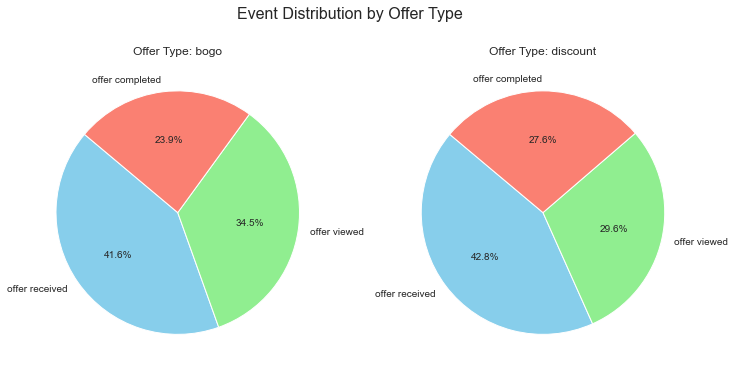

In [537]:
offer_types = ['bogo', 'discount']

# Set up the figure size and layout
fig, axes = plt.subplots(1, len(offer_types), figsize=(len(offer_types)*6, 6))

for ax, offer_type in zip(axes, offer_types):

    if offer_type == 'informational':
        pass
    else:
        # Filter the DataFrame by offer type
        data = bogo_discount_notcleaned[bogo_discount_notcleaned['offer_type'] == offer_type]
        
        # Prepare data for pie chart
        event_counts = data['event'].value_counts()
        
        # Plot pie chart
        ax.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
        ax.set_title(f'Offer Type: {offer_type}')

plt.suptitle('Event Distribution by Offer Type', fontsize=16)
plt.show()


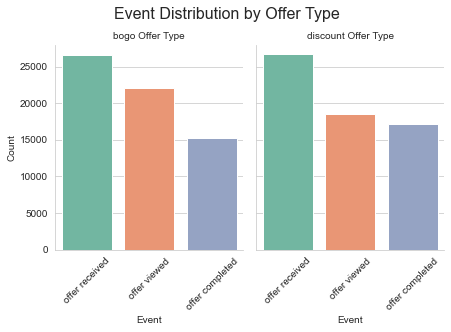

In [539]:
# Create a FacetGrid, using offer_type for each subplot
g = sns.catplot(x='event', col='offer_type', data=bogo_discount_notcleaned, kind='count',
                height=4, aspect=.8, palette='Set2')

# Rotate x-axis labels for clarity
g.set_xticklabels(rotation=45)

# Set titles and labels
g.set_titles('{col_name} Offer Type')
g.set_axis_labels('Event', 'Count')

# Adjust the title of the entire figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Event Distribution by Offer Type', fontsize=16)

plt.show()

In [541]:
def counting_events(df):
    """
    Generate counts of occurrences for each unique event in the dataframe.

    Parameters:
    - df (pd.DataFrame): The input dataframe containing an 'event' column.

    Yields:
    - int: Count of occurrences for each unique event in the input dataframe.
    """
    event_counts = df['event'].value_counts().to_dict()
    for event, count in event_counts.items():
        yield (event, count)

In [548]:
#event counts

bogo_df = combined_df[combined_df['offer_type']=='bogo']
discount_df = combined_df[combined_df['offer_type']=='discount']

bogo_received, bogo_viewed, bogo_completed = counting_events(bogo_df)

discount_received, discount_viewed, discount_completed = counting_events(discount_df)

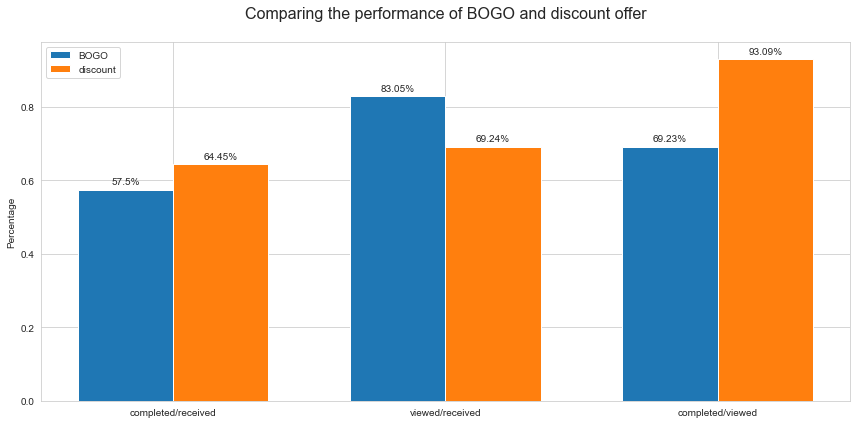

In [554]:
labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo_completed[1]/bogo_received[1], bogo_viewed[1]/bogo_received[1], bogo_completed[1]/bogo_viewed[1]]
discount_performance = [discount_completed[1]/discount_received[1], discount_viewed[1]/discount_received[1], discount_completed[1]/discount_viewed[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offer\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

The efficacy of discount offers notably exceeds that of BOGO offers, highlighted by the subtly higher occurrence of 'offer completed' statuses and a completed-to-received ratio that is superior by roughly 7%. While BOGO offers are more likely to catch the attention of customers, discounts prove to be more efficient in converting received offers into completed ones.

The following assessment shows as well that discount has a higher success rate than bogo:

In [555]:
prepared_data_df.groupby('offer')['success'].mean().reset_index().sort_values(by='success', ascending=False)

,offer,success
4,discount_2_for_10_in_10days,0.691371
6,discount_3_for_7_in_7days,0.665214
8,informational_0_for_0_in_3days,0.640373
2,bogo_5_for_5_in_5days,0.563108
0,bogo_10_for_10_in_5days,0.457455
1,bogo_10_for_10_in_7days,0.435583
9,informational_0_for_0_in_4days,0.382605
3,bogo_5_for_5_in_7days,0.374869
5,discount_2_for_10_in_7days,0.367667
7,discount_5_for_20_in_10days,0.243533


In [514]:
# Assuming you have two DataFrames, df1 and df2
are_identical = info_df.equals(info_cleaned)
print(are_identical)

True


## Prediction Model


After conducting initial data examination and cleansing, while also addressing several queries, I am now poised to delve deeper into the dataset. The forthcoming step involves developing a straightforward machine learning model. This model aims to forecast the likelihood of offer success, utilizing both offer details and customer attributes as predictive variables.

Evaluation Metrics employed in this context include the accuracy score and the ROC AUC score.

In [563]:
def build_classification_model(df, target, target_names, model=None):
    """
    Constructs and evaluates a classification model using the provided dataset.

    Parameters:
    - df (DataFrame): The dataset for analysis.
    - target (str): The name of the target variable.
    - target_names (list): A list of labels for the target variable classes.
    - model (sklearn estimator, optional): The machine learning model to be used. 
      Defaults to RandomForestClassifier with max_depth=20 and random_state=42.

    Returns:
    - The trained classification model.
    """
    if model is None:
        model = RandomForestClassifier(max_depth=20, random_state=42)
    
    # Preprocess the dataset
    df_clean = df.dropna()
    df_encoded = pd.get_dummies(df_clean, columns=['gender'], drop_first=True)
    
    excluded_columns = ['customer_id', 'offer_id', 'time', 'offer_type', 'offer', 'success',
                        'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed', 'offer received', 'offer viewed', 'transaction']
    X = df_encoded.drop(columns=excluded_columns + [target])
    y = df_encoded[target]
    
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Model training
    model.fit(X_train, y_train)
    
    # Model evaluation
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions, target_names=target_names))
    print(f"Overall model accuracy: {accuracy_score(y_test, predictions):.4f}")
    
    # AUC scores
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    print(f"Train ROC AUC score: {roc_auc_score(y_train, train_probs):.4f}")
    print(f"Test ROC AUC score: {roc_auc_score(y_test, test_probs):.4f}")
    
    return model

In [565]:
random_forest_model = build_classification_model(df=prepared_data_df, 
                                                 target='success', 
                                                 target_names=['Failure', 'Success'])

              precision    recall  f1-score   support

     Failure       0.72      0.71      0.71     10390
     Success       0.69      0.69      0.69      9561

    accuracy                           0.70     19951
   macro avg       0.70      0.70      0.70     19951
weighted avg       0.70      0.70      0.70     19951

Overall model accuracy: 0.7033
Train ROC AUC score: 0.9960
Test ROC AUC score: 0.7683


In [567]:
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

model_gb = build_classification_model(df=prepared_data_df, 
                                      target='success', 
                                      target_names=['Failure', 'Success'],
                                      model=gradient_boosting_model)

              precision    recall  f1-score   support

     Failure       0.69      0.71      0.70     10390
     Success       0.68      0.66      0.67      9561

    accuracy                           0.69     19951
   macro avg       0.69      0.68      0.68     19951
weighted avg       0.69      0.69      0.69     19951

Overall model accuracy: 0.6857
Train ROC AUC score: 0.7546
Test ROC AUC score: 0.7527


In [569]:
ada_boost_model = AdaBoostClassifier(random_state=42)

# Call the updated and refactored function with the AdaBoost classifier
overall_model = build_classification_model(df=prepared_data_df, 
                                           target='success', 
                                           target_names=['Failure', 'Success'],
                                           model=ada_boost_model)

              precision    recall  f1-score   support

     Failure       0.68      0.68      0.68     10390
     Success       0.66      0.66      0.66      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy: 0.6711
Train ROC AUC score: 0.7296
Test ROC AUC score: 0.7299


In [570]:
overall_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

### Optimize the model using GridSearchCV

In [572]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.1, 0.7, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

# Preprocessing the data
def preprocess_data(df):
    """
    Preprocesses the given DataFrame by dropping missing values, encoding categorical variables,
    and separating features from the target variable.
    
    Parameters:
    - df (DataFrame): The dataset to preprocess.

    Returns:
    - X (DataFrame): The features matrix.
    - y (Series): The target variable.
    """
    df_prep = df.dropna()
    df_encoded = pd.get_dummies(df_prep, columns=['gender'], drop_first=True)
    
    excluded_columns = ['customer_id', 'offer_id', 'time', 'offer_type', 'offer',
                        'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor',
                        'offer completed', 'offer received', 'offer viewed', 'transaction']
    X = df_encoded.drop(columns=excluded_columns)
    y = df_encoded['success']
    
    return X, y

X, y = preprocess_data(prepared_data_df)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cv = GridSearchCV(overall_model, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')

# Fitting GridSearchCV
best_model = cv.fit(X_train, y_train)

# Extracting best parameters
best_params = best_model.best_params_
print("Best parameters found: ", best_params)


Best parameters found:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}


In [573]:
# Prepare the optimized AdaBoostClassifier model with specific hyperparameters
optimized_model = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=0.1,
    algorithm='SAMME.R',
    random_state=42
)

# Build and evaluate the model using the refactored function name and the optimized model
final_model = build_classification_model(
    df=prepared_data_df, 
    target='success', 
    target_names=['Failure', 'Success'],
    model=optimized_model
)

              precision    recall  f1-score   support

     Failure       0.68      0.68      0.68     10390
     Success       0.65      0.66      0.65      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy: 0.6690
Train ROC AUC score: 0.7295
Test ROC AUC score: 0.7303


The accuracy is slighly worse then model_gb, which is why model_gb will be used in the further analysis.

In [577]:
def identify_important_features(X, model):
    """
    Identifies and visualizes the most important features used by the model.

    Parameters:
    - X (pd.DataFrame): The features DataFrame.
    - model (model object): The trained classification model with feature_importances_ attribute.

    Returns:
    - pd.DataFrame: DataFrame containing features and their importance, sorted by importance.
    """
    # Ensure the model has 'feature_importances_' attribute
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("Model does not have feature importances attribute")

    # Create DataFrame of feature importances
    feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, 
                                       columns=['importance']).sort_values('importance', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y=feature_importances.index, data=feature_importances,
                palette='coolwarm')  # Changed color palette to 'coolwarm'
    plt.title('Feature Importance', fontsize=20)
    plt.xlabel('Importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Added grid lines for better readability
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return feature_importances


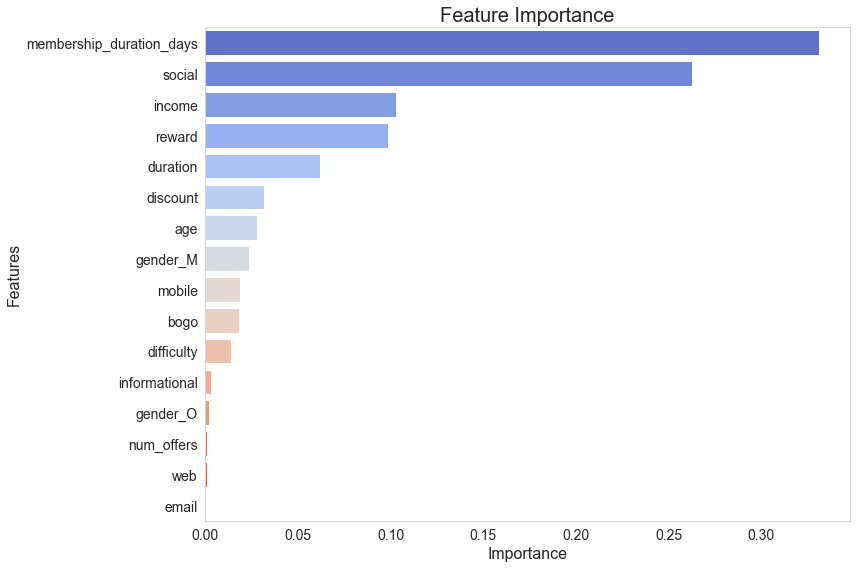

In [578]:
important_features = identify_important_features(X_train, model_gb)

As can be seen in the plot, membership_duration_days, social, income and reward are the most important features of the model

In [580]:
average_success_rate = prepared_data_df.groupby('num_offers')['success'].mean()
average_income_by_success = prepared_data_df.groupby('success')['income'].mean()
average_success_by_social = prepared_data_df.groupby('social')['success'].mean()

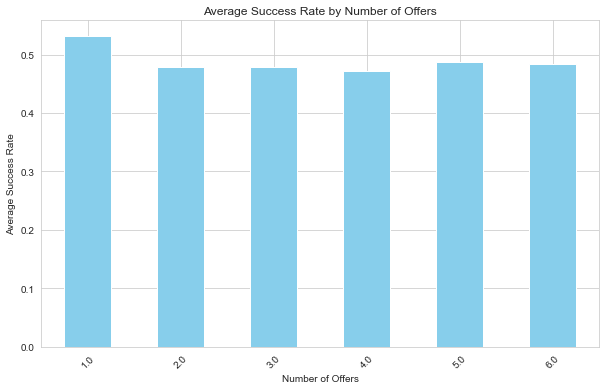

In [585]:
average_success_rate.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average Success Rate by Number of Offers')
plt.xlabel('Number of Offers')
plt.ylabel('Average Success Rate')
plt.xticks(rotation=45)
plt.show()

Offers often achieve higher success rates when the total count of received offers is either exceptionally low or extremely high, indicating a U-shaped correlation. This pattern could merely be a matter of chance.

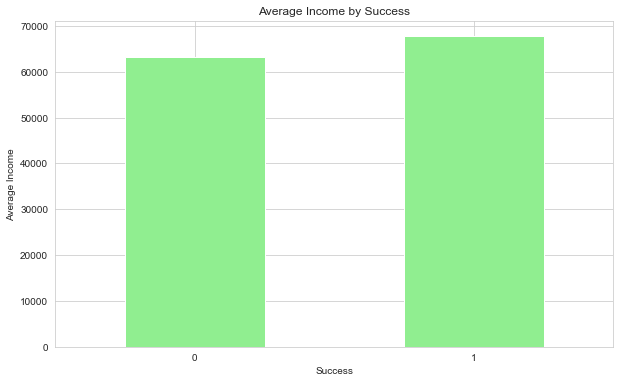

In [586]:
average_income_by_success.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Average Income by Success')
plt.xlabel('Success')
plt.ylabel('Average Income')
plt.xticks(rotation=0)  # Adjust depending on your data
plt.show()


Members with higher incomes tend to experience a greater success rate with offers.

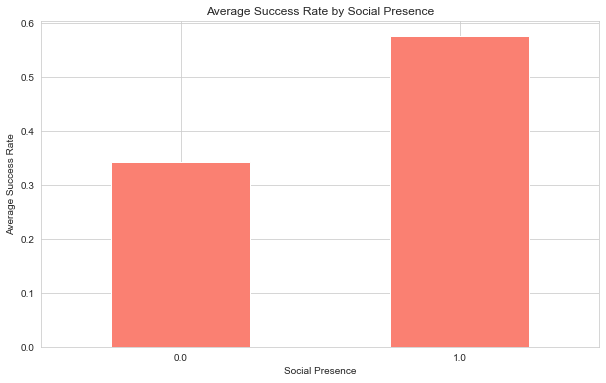

In [587]:
average_success_by_social.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Average Success Rate by Social Presence')
plt.xlabel('Social Presence')
plt.ylabel('Average Success Rate')
plt.xticks(rotation=0)  # Adjust depending on your data
plt.show()

Offers disseminated through the 'social' channel often see increased rates of success.

## Summary

### Findings

The objective of this study was to determine the likelihood of offer acceptance utilizing the data provided on offers and customer demographics. A straightforward predictive model was developed, employing various classifiers including RandomForestClassifier, GradientBoostingClassifier, and AdaBoostClassifier, among which the AdaBoostClassifier emerged as the most effective for this scenario.

The AdaBoostClassifier demonstrates the capability to forecast the successful completion of an offer by analyzing the traits of both the customer and the offer itself. Achieving an accuracy rate of 67%, the model presents a solid foundation for business applications, though it also highlights opportunities for further refinement.

Key determinants influencing the success of an offer, as identified by the model, include:

1. Length of membership
2. Earnings
3. Age
4. Duration of the offer

Throughout the process of model development, several questions were explored and addressed, such as:
- Identifying the most effective offer:
    - The discount offer outperforms the BOGO offer, not just in the sheer volume of 'offer completed' instances but also in a superior complete-to-receive ratio by approximately 7%. While BOGO offers are more frequently noticed by consumers, discounts are more likely to convert an offer from received to completed.
- Determining who spends more, men or women?
    - Analysis of the data reveals that women tend to spend more, providing valuable insight into customer targeting strategies for businesses like Starbucks.

Suggestions for future enhancement include:

- Investigating more advanced modeling techniques and algorithms to assess potential improvements in model accuracy.
- Avoiding the exclusion of data entries with missing values in favor of implementing imputation methods could offer a pathway to further enhance model performance.
